# 🤖  Mini-Transformer with NumPy: A Hands-On Tutorial

Author: Ioana Ciucă + Claude Opus 4.1 

## Learning Objectives

By completing this tutorial, you will:
- Understand the fundamental building blocks of transformers
- Implement a transformer with a single attention head from tokenization -> embedding + positional encoding -> attention head -> output logits.
- Visualize how attention works

Through this tutorial, you will implement the folllowing:
#### 1. **Tokenizer** 
Transform text into numbers that the model can process

#### 2. **Embeddings & Positional Encoding** 
- Token embeddings: Learn representations for each token
- Sinusoidal positional encoding: Tell the model about word order

#### 3. **Single-Head Causal Self-Attention** 
The heart of the transformer:
- **Query (Q)**, **Key (K)**, **Value (V)** projections
- Attention scores with causal masking
- Softmax normalization
- Simple residual connections

#### 4. **Output Layer** 
Linear transformation to predict the next token


## Imports & helpers

In [21]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

## Part 1: The Tokenizer: From Text to Numbers

Before a neural network can understand text, we need to convert words into numbers. This process, called **tokenization**, is the foundation of every language model, from BERT to GPT.

### How Our Simple Tokenizer Works

#### 1. **Splitting Text into Tokens** 
We separate words and punctuation, treating each as its own unit:
- `"Hello, world!"` → `["Hello", ",", "world", "!"]`
- Punctuation becomes separate tokens (important for understanding sentence structure!)

#### 2. **Building a Vocabulary**
We scan all training texts and create a mapping:
```python
token_to_id = {
    "<pad>": 0,   # Padding for batch processing
    "<bos>": 1,   # Beginning of sequence
    "<eos>": 2,   # End of sequence  
    "<unk>": 3,   # Unknown/rare words
    "the": 4,
    "hello": 5,
    ...
}
```
Tokens are ordered by frequency, with common words geting lower IDs.

#### 3. **Encoding: Text → Numbers**
Convert any text into a sequence of IDs:
- `"Hello world"` → `[1, 5, 87, 2]` (with BOS/EOS tokens)
- Unknown words map to `<unk>` token

#### 4. **Decoding: Numbers → Text**
Reverse the process to see what the model "sees":
- `[5, 87]` → `"hello world"`

In [ ]:
def split_tokens(text):
    """Split text into words and punctuation tokens"""
    # Step 1: Mark punctuation with spaces
    punct = '.,!?;:"()[]{}'
    text_with_spaces = ""

    for character in text:
        if character in punct:
            # Add spaces around punctuation
            text_with_spaces += " " + character + " "
        else:
            text_with_spaces += character

    # Step 2: Split by spaces to get tokens
    tokens = text_with_spaces.split()
    return tokens

def build_vocab(texts):
    """Build vocabulary from training texts"""
    # Start with special tokens
    token_to_id = {}
    token_to_id["<pad>"] = 0  # for padding sequences
    token_to_id["<bos>"] = 1  # beginning of sequence
    token_to_id["<eos>"] = 2  # end of sequence
    token_to_id["<unk>"] = 3  # unknown words

    # Step 1: Count how often each token appears
    token_counts = {}
    for text in texts:
        text_lower = text.lower()
        tokens = split_tokens(text_lower)

        for token in tokens:
            if token in token_counts:
                token_counts[token] += 1
            else:
                token_counts[token] = 1

    # Step 2: Sort tokens by frequency (most common first)
    sorted_tokens = []
    for token, count in token_counts.items():
        sorted_tokens.append((token, count))
    sorted_tokens.sort(key=lambda x: x[1], reverse=True)

    # Step 3: Assign IDs to tokens
    next_id = 4  # Start after special tokens
    for token, count in sorted_tokens:
        if token not in token_to_id:
            token_to_id[token] = next_id
            next_id += 1

    # Step 4: Create reverse mapping (ID to token)
    id_to_token = {}
    for token, token_id in token_to_id.items():
        id_to_token[token_id] = token

    return token_to_id, id_to_token

def encode(text, token_to_id, add_bos=False, add_eos=False):
    """Convert text to list of token IDs"""
    # Convert to lowercase and split into tokens
    text_lower = text.lower()
    tokens = split_tokens(text_lower)

    # Convert each token to its ID
    ids = []
    for token in tokens:
        if token in token_to_id:
            ids.append(token_to_id[token])
        else:
            # Use <unk> for unknown tokens
            ids.append(token_to_id["<unk>"])

    # Add special tokens if requested
    if add_bos:
        ids = [token_to_id["<bos>"]] + ids
    if add_eos:
        ids = ids + [token_to_id["<eos>"]]

    return np.array(ids, dtype=np.int64)

def decode(ids, id_to_token):
    """Convert list of token IDs back to text"""
    tokens = []

    for token_id in ids:
        # Convert ID to token
        if token_id in id_to_token:
            token = id_to_token[token_id]

            # Skip special tokens in output
            if token not in ["<bos>", "<eos>", "<pad>"]:
                tokens.append(token)
        else:
            tokens.append("<unk>")

    # Join tokens with spaces
    text = " ".join(tokens)
    return text

### Try it out :)

In [32]:
# Example usage
texts = ["Hello world!", "Hello there.", "World peace."]

# Build vocabulary
token_to_id, id_to_token = build_vocab(texts)
print(f"Vocabulary size: {len(token_to_id)}")
print(f"First 10 tokens: {list(token_to_id.items())[:10]}")

# Encode a sentence
sentence = "Hello, world!"
ids = encode(sentence, token_to_id, add_bos=True, add_eos=True)
print(f"\nOriginal: {sentence}")
print(f"Token IDs: {ids}")

# Decode back
decoded = decode(ids, id_to_token)
print(f"Decoded: {decoded}")

Vocabulary size: 10
First 10 tokens: [('<pad>', 0), ('<bos>', 1), ('<eos>', 2), ('<unk>', 3), ('hello', 4), ('world', 5), ('.', 6), ('!', 7), ('there', 8), ('peace', 9)]

Original: Hello, world!
Token IDs: [1 4 3 5 7 2]
Decoded: hello <unk> world !


## We can build and understand a tiny astronomy-flavored text corpus.

In [43]:
texts = [
    "O B A F G K M O B A F G K M O B A F G K M .",
    "Mercury Venus Earth Mars Jupiter Saturn Uranus Neptune .",
    "The Sun is a G type star in the Milky Way .",
    "Betelgeuse is an M type star .",
    "Rigel is a B type star .",
    "Sirius is an A type star .",
    "Andromeda is also called M31 ."
]

token_to_id, id_to_token =  build_vocab(texts) #TODO: add your code here
vocab_size = len(token_to_id)

print("Vocab size:", vocab_size)
print(f"First 20 tokens: {list(token_to_id.items())[:20]}")

Vocab size: 36
First 20 tokens: [('<pad>', 0), ('<bos>', 1), ('<eos>', 2), ('<unk>', 3), ('.', 4), ('a', 5), ('is', 6), ('b', 7), ('g', 8), ('m', 9), ('type', 10), ('star', 11), ('o', 12), ('f', 13), ('k', 14), ('the', 15), ('an', 16), ('mercury', 17), ('venus', 18), ('earth', 19)]


In [ ]:
# Install: pip install tiktoken
import tiktoken

def demo_real_tokenization():
    """Show how GPT actually tokenizes text"""

    # Get GPT-2's tokenizer
    enc = tiktoken.get_encoding("gpt2")

    # Example text
    text = "The Sun is a G type star in the Milky Way."

    # Tokenize
    tokens = enc.encode(text)

    print("Original text:", text)
    print(f"Token IDs: {tokens}")
    print(f"Number of tokens: {len(tokens)}")

    # Show each token
    print("\nToken breakdown:")
    for token_id in tokens:
        token_str = enc.decode([token_id])
        print(f"  {token_id:5d} → '{token_str}'")

    # Compare with character tokenization
    char_tokens = list(text)
    print(f"\nCharacter tokenization would use {len(char_tokens)} tokens")
    print(f"GPT-2 tokenization uses {len(tokens)} tokens")
    print(f"Efficiency gain: {len(char_tokens)/len(tokens):.1f}x")

    # Show subword tokenization
    interesting_words = [
        "unbelievable",
        "artificial",
        "consciousness",
        "Mars",
        "M31"
    ]

    print("How GPT-2 splits words:")
    for word in interesting_words:
        tokens = enc.encode(word)
        pieces = [enc.decode([t]) for t in tokens]
        print(f"  '{word}' → {pieces}")

# Run the demo
demo_real_tokenization()

Original text: The Sun is a G type star in the Milky Way.
Token IDs: [464, 3825, 318, 257, 402, 2099, 3491, 287, 262, 34822, 6378, 13]
Number of tokens: 12

Token breakdown:
    464 → 'The'
   3825 → ' Sun'
    318 → ' is'
    257 → ' a'
    402 → ' G'
   2099 → ' type'
   3491 → ' star'
    287 → ' in'
    262 → ' the'
  34822 → ' Milky'
   6378 → ' Way'
     13 → '.'

Character tokenization would use 42 tokens
GPT-2 tokenization uses 12 tokens
Efficiency gain: 3.5x
How GPT-2 splits words:
  'unbelievable' → ['un', 'bel', 'iev', 'able']
  'artificial' → ['art', 'ificial']
  'consciousness' → ['conscious', 'ness']
  'Mars' → ['Mars']
  'M31' → ['M', '31']


In [41]:
print("Our Simple Tokenizer:")
print(f"Vocabulary size: {vocab_size}")
print(f"Tokens for 'The Sun': {encode('The Sun', token_to_id)}")

print("How GPT-2 Would Tokenize:")
enc = tiktoken.get_encoding("gpt2")
print(f"Vocabulary size: {enc.n_vocab}")  # 50,257!
print(f"Tokens for 'The Sun': {enc.encode('The Sun')}")

Our Simple Tokenizer:
Vocabulary size: 36
Tokens for 'The Sun': [15 25]
How GPT-2 Would Tokenize:
Vocabulary size: 50257
Tokens for 'The Sun': [464, 3825]


## Q1: Exploring Your Tokenizer

You've built a tokenizer using this astronomy corpus:

```python
texts = [
    "O B A F G K M O B A F G K M O B A F G K M .",
    "Mercury Venus Earth Mars Jupiter Saturn Uranus Neptune .",
    "The Sun is a G type star in the Milky Way .",
    "Betelgeuse is an M type star .",
    "Rigel is a B type star .",
    "Sirius is an A type star .",
    "Andromeda is also called M31 ."
]
```

1. **Without running code**, predict which regular word (not special token) will have the lowest ID? Why?

2. **Encode patterns**: Encode these sentences and answer why the first two sentences produce different results?

```python
test_sentences = [
    "The Sun .",
    "the sun .",
    "Betelgeuse is a star .",
    "Proxima Centauri is a star .",
    "A B C D E F G ."
]
```

In [ ]:
# TODO: add your code here

## 2. Embeddings + Sinusoidal Position Encoding

Remember our tokens `[5, 87, 42]`? These numbers don't mean anything to a neural network yet. We need to convert each token into a **vector**, a list of decimal numbers that can capture meaning.

Think of it like this:
- Token ID `5` (maybe "cat") → `[0.2, -0.1, 0.8, ...]` 
- Token ID `87` (maybe "dog") → `[0.3, -0.2, 0.7, ...]`

These vectors can learn that "cat" and "dog" are similar (both animals) by having similar values!

## The Problem with Order

Transformers process all tokens at once (unlike RNNs that go step-by-step). But word order matters!
- "The cat ate the mouse" ≠ "The mouse ate the cat" 🐱🐭

**Solution:** Add position information to each embedding using **sinusoidal positional encoding**.

In [ ]:
def init_embeddings(vocab_size, d_model, scale=0.02, seed=0):
    """Create random embedding vectors for each token in vocabulary"""
    rng = np.random.RandomState(seed)
    return rng.randn(vocab_size, d_model).astype(np.float32) * scale

def sinusoidal_positional_encoding(T, d_model):
    """Create unique position vectors using sine/cosine waves"""
    pe = np.zeros((T, d_model), dtype=np.float32)

    # For each position in the sequence
    for pos in range(T):
        # For each dimension of the embedding
        for i in range(0, d_model, 2):
            # Calculate the divisor for this dimension
            # This creates different frequencies for different dimensions
            divisor = 10000.0 ** (i / d_model)

            # Apply sine to even dimensions
            pe[pos, i] = np.sin(pos / divisor)

            # Apply cosine to odd dimensions (if not last dimension)
            if i + 1 < d_model:
                pe[pos, i + 1] = np.cos(pos / divisor)

    return pe

def embed(token_ids, W_E, PE):
    """Combine token embeddings with positional information"""
    return W_E[token_ids] + PE[:len(token_ids)]

## Q2: Explore embeddings

In [ ]:
d_model = 48
vocab_size = len(token_to_id)
W_E = init_embeddings(vocab_size, d_model, scale=0.02, seed=42)
PE = sinusoidal_positional_encoding(T=100, d_model=d_model)

# TODO: Print W_E and PE
# print(f"W_E: {W_E}")
# print(f"PE shape: {PE}")

# TODO: Print the shapes
# print(f"W_E shape: {W_E.shape} means ...")
# print(f"PE shape: {PE.shape} means ...")

### 2. Extract Sun's Embedding

# TODO: Get the embedding vector for "sun"
# sun_id = token_to_id["sun"]
# sun_embedding = W_E[...]
# print(f"'sun' embedding (first 5 dims): {sun_embedding[:5]}")

### 3. Same Word, Different Positions

sentence = "star type star ."
token_ids = encode(sentence, token_to_id)
embedded = embed(token_ids, W_E, PE)

# TODO: Compare "star" at position 0 vs position 2
# print(f"'star' at position 0: {embedded[0][:5]}")
# print(f"'star' at position 2: {embedded[2][:5]}")
# print("Are they the same?", ...)

## For more info, you can have a more in depth read here.

https://alessiodevoto.github.io/LLM-Embedding-Space/

## 3. Single-Head Attention — Parameters & Forward

## What is Softmax?

Softmax converts a list of numbers (scores) into probabilities that sum to 1.

**Input:** Any list of numbers, like `[2, 5, 1]`  
**Output:** Probabilities that sum to 1, like `[0.04, 0.87, 0.09]`

For each score $z_i$ in your list:

$$\text{probability}_i = \frac{e^{z_i}}{\text{sum of all } e^z}$$

### Example
Given scores `[2, 5, 1]`:
- Calculate: $e^2 \approx 7.4$, $e^5 \approx 146.1 $, $e^1 \approx 2.7$
- Sum: $7.4 + 146.1 + 2.7 = 156.2$
- Probabilities: $[7.4/156.2, 146.4/156.2, 2.7/156.2] = [0.05, 0.94, 0.02]$

The highest score (5) gets the highest probability (94%).

### Why Use Softmax?

1. **Creates valid probabilities**: All outputs between 0 and 1, sum to 1
2. **Preserves order**: Higher scores → higher probabilities
3. **Differentiable**: Works well with neural networks


### Numerical Stability Trick

**Problem:** $e^{1000}$ causes overflow!

**Solution:** Subtract the maximum score first.

In [ ]:
def stable_softmax(x, axis=-1):
    """
    TODO-1: Implement numerically stable softmax along `axis`.
    Steps:
      1) subtract the row-wise max
      2) exponentiate
      3) divide by row-wise sum
    """
    # ----- YOUR CODE -----
    #
    #
    #
    raise NotImplementedError("TODO-1: stable_softmax")


In [ ]:
def test_softmax():
    """Simple test case for stable_softmax"""

    # Test input: scores for 3 classes
    x = np.array([2.0, 5.0, 1.0])

    # Run your implementation
    probs = stable_softmax(x)

    # Check if it sums to 1
    assert np.isclose(probs.sum(), 1.0), f"Probabilities don't sum to 1: {probs.sum()}"

    # Check expected values (approximately)
    expected = np.array([0.0466, 0.9362, 0.0172])
    assert np.allclose(probs, expected, atol=0.01), f"Got {probs}, expected ~{expected}"

    print("✅ Test passed!")
    print(f"Input:  {x}")
    print(f"Output: {probs}")
    print(f"Sum:    {probs.sum()}")

    return x, probs


scores, probs = test_softmax()

[2. 5. 1.]


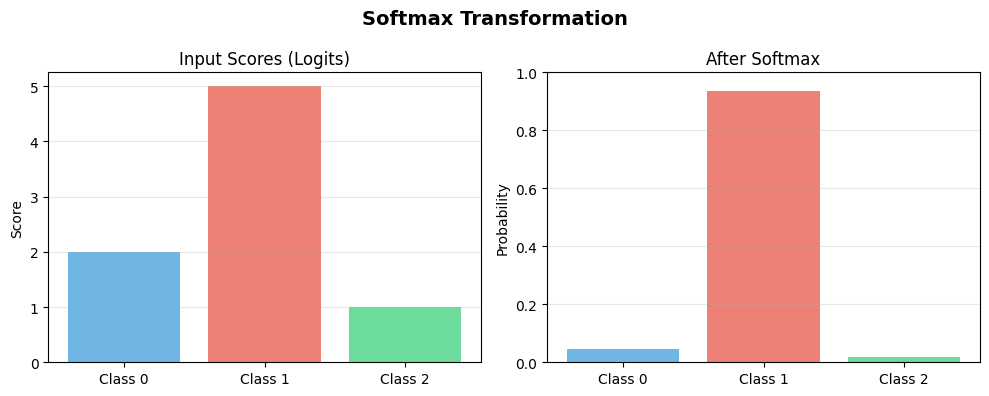


 Try different scores to see how softmax behaves:
Example: test_scores = np.array([1, 1, 1]) for uniform distribution
Example: test_scores = np.array([10, 0, 0]) for very confident prediction


In [49]:
# Visualize how softmax transforms scores to probabilities
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot 1: Input scores
classes = ['Class 0', 'Class 1', 'Class 2']
colors = ['#3498db', '#e74c3c', '#2ecc71']

print(scores)
scores = scores # you can vary here to see how softmax behaves, for example: np.array([1, 1, 1])

ax1.bar(classes, scores, color=colors, alpha=0.7)
ax1.set_ylabel('Score')
ax1.set_title('Input Scores (Logits)')
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Output probabilities
ax2.bar(classes, probs, color=colors, alpha=0.7)
ax2.set_ylabel('Probability')
ax2.set_title('After Softmax')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)

plt.suptitle('Softmax Transformation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Interactive experiment
print("\n Try different scores to see how softmax behaves:")
print("Example: test_scores = np.array([1, 1, 1]) for uniform distribution")
print("Example: test_scores = np.array([10, 0, 0]) for very confident prediction")

In [48]:
def one_hot(idx, vocab):
    v = np.zeros((vocab,), dtype=np.float32);
    v[idx] = 1.0
    return v

def causal_mask(T):
    """
    TODO-2: Return an upper-triangular boolean mask of shape (T, T)
    where True means 'mask out' (disallow attending to future).
    Hint: np.triu with k=1
    """
    # ----- YOUR CODE -----
    # return ...
    raise NotImplementedError("TODO-2: causal_mask")

def apply_causal_mask(scores, mask):
    # mask True → set to large negative so softmax ~ 0
    return np.where(mask, -1e9, scores)

In [ ]:
def init_attention_params(d_model, scale=0.02, seed=1):
    rng = np.random.RandomState(seed)
    W_Q = rng.randn(d_model, d_model).astype(np.float32) * scale
    W_K = rng.randn(d_model, d_model).astype(np.float32) * scale
    W_V = rng.randn(d_model, d_model).astype(np.float32) * scale
    W_O = rng.randn(d_model, d_model).astype(np.float32) * scale
    return {"W_Q": W_Q, "W_K": W_K, "W_V": W_V, "W_O": W_O}

attn_params = init_attention_params(d_model, scale=0.02, seed=1)

def attention_forward(X, attn_params):
    """
    TODO-3: Implement scaled dot-product attention (causal).
    Given X (T, D) and attn_params, compute:
      Q = X @ W_Q
      K = X @ W_K
      V = X @ W_V
      scores = (Q @ K.T) / sqrt(D)
      scores_masked = apply_causal_mask(scores, causal_mask(T))
      A = softmax(scores_masked, axis=-1)
      Z = A @ V
      Y = Z @ W_O
    Return Y and a cache dict with Q, K, V, A for later use.
    """
    T, D = X.shape
    W_Q, W_K, W_V, W_O = attn_params["W_Q"], attn_params["W_K"], attn_params["W_V"], attn_params["W_O"]
    # ----- YOUR CODE -----
    # Q = ...
    # K = ...
    # V = ...
    # scores = ...
    # S = ...
    # A = ...
    # Z = ...
    # Y = ...
    raise NotImplementedError("TODO-3: attention_forward")

## 4. Output Layer + Loss (Cross-Entropy)

In [ ]:
def init_output_params(d_model, vocab_size, scale=0.02, seed=2):
    rng = np.random.RandomState(seed)
    W_out = rng.randn(d_model, vocab_size).astype(np.float32) * scale
    b_out = np.zeros((vocab_size,), dtype=np.float32)
    return {"W_out": W_out, "b_out": b_out}

out_params = init_output_params(d_model, vocab_size, scale=0.02, seed=2)

def logits_forward(H, out_params):
    return H @ out_params["W_out"] + out_params["b_out"]

def next_token_targets(ids):
    return ids[1:]  # predict next token

def loss_and_grad_logits(logits, target_ids):
    """
    TODO-4: Cross-entropy loss and gradient wrt logits.

    logits: (T, V) - only first T-1 rows have targets
    target_ids: (T-1,)

    Steps:
      1) P = softmax(logits, axis=-1)
      2) loss = -mean(log P[0:T-1, target_ids])
      3) dlogits = P; subtract 1 at true classes on rows 0..T-2; divide by (T-1)
      4) zero the last row's gradient
    Return (loss, dlogits)
    """
    T, V = logits.shape
    assert len(target_ids) == T-1
    # ----- YOUR CODE -----
    # P = ...
    # loss = ...
    # dlogits = ...
    raise NotImplementedError("TODO-4: loss_and_grad_logits")

## 9. Attention Map Visualization (nice heatmap)

In [ ]:
def plot_attention(A, tokens, title="Attention (rows=query, cols=key)"):
    """
    A: (T, T) attention matrix
    tokens: list of token strings length T
    """
    T = len(tokens)
    fig, ax = plt.subplots(figsize=(max(6, T*0.5), max(4, T*0.4)))
    im = ax.imshow(A)  # default colormap
    ax.set_xticks(np.arange(T))
    ax.set_yticks(np.arange(T))
    ax.set_xticklabels(tokens, rotation=45, ha="right")
    ax.set_yticklabels(tokens)
    ax.set_xlabel("Keys (source positions)")
    ax.set_ylabel("Queries (destination positions)")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    # annotate top-1 per row
    for i in range(T):
        j = int(np.argmax(A[i]))
        ax.text(j, i, f"{A[i, j]:.2f}", ha="center", va="center")
    plt.tight_layout()
    plt.show()

def attention_for_prompt(prompt, params, d_model, token_to_id, id_to_token):
    ids = encode(prompt, token_to_id, add_bos=False, add_eos=False)
    T = len(ids)
    PE = sinusoidal_positional_encoding(T, d_model)
    X = embed(ids, params["W_E"], PE)
    Y, cache = attention_forward(X, params["attn"])
    A = cache["A"]
    tokens = [id_to_token[int(i)] for i in ids]
    return A, tokens

### Exercise A — Interpret an attention map
**Task:** Use your trained params to visualize attention on a short astronomy prompt and **explain** what each row is focusing on.

**Instructions:**
1. Run the cell to compute and plot the map.
2. Fill the "TODO" to compute the **top-1 attended token** per row and print a readable summary.
3. In your own words (markdown cell), write what you observe.

In [ ]:
prompt = "O B A F G K M O B A F"
A, tokens = attention_for_prompt(prompt, params, d_model, token_to_id, id_to_token)
plot_attention(A, tokens, title=f"Attention for: {prompt}")

# TODO-A1: Print the top attended token per row
# For each row i, find j = argmax(A[i]) and print tokens[i] attends-to tokens[j] with weight
# ----- YOUR CODE -----
# for i in range(len(tokens)):
#     j = ...
#     w = ...
#     print(f"row {i:2d} ({tokens[i]:>6s}) → attends to {tokens[j]:>6s} (w={w:.2f})")
raise NotImplementedError("TODO-A1: summarize attention rows")

### Exercise B — Compare two prompts
**Task:** Compare attention on a spectral snippet versus a planetary snippet.

**Instructions:**  
1. Plot maps for:
   - `"O B A F G"`
   - `"Mercury Venus Earth Mars Jupiter"`  
2. Describe whether attention prefers near neighbors (`i-1`) or specific content (e.g., always focusing on certain markers).

In [ ]:
for prompt in ["O B A F G", "Mercury Venus Earth Mars Jupiter"]:
    A, tokens = attention_for_prompt(prompt, params, d_model, token_to_id, id_to_token)
    plot_attention(A, tokens, title=f"Attention for: {prompt}")
# Write your observations in a markdown cell below.

## 10. The "Move" Part (OV) — Copying information

In attention, **A** decides *where to read*, and **V** carries *what we copy*. To make this concrete,
we'll build a **toy V** that is a one-hot of token identity. Then **A @ V** literally copies the identity
of the attended token.

**Exercise C — OV copy with one-hots**
1. Build `V_onehot = I[vocab][ids]` (shape `(T, V)`).
2. Compute `Y_copy = A @ V_onehot`.
3. For each row, pick `argmax` to see the copied identity and print the token.

In [ ]:
prompt = "O B A F G K M O B A F"
ids = encode(prompt, token_to_id, add_bos=False, add_eos=False)
T = len(ids)
A, tokens = attention_for_prompt(prompt, params, d_model, token_to_id, id_to_token)

# TODO-C1: Implement the OV toy copy using one-hot values
# ----- YOUR CODE -----
# V_onehot = ...
# Y_copy   = ...
# pred_ids = ...
# pred_tokens = ...
raise NotImplementedError("TODO-C1: OV copy (A @ one-hot V)")

# Expected behavior: If row i attends to column j, the predicted token for row i should be tokens[j].

## 11. Greedy Generation (qualitative check)

In [ ]:
def generate(prompt, max_new_tokens, params, token_to_id, id_to_token, d_model, T_ctx=16):
    ids = encode(prompt, token_to_id, add_bos=False, add_eos=False)
    ids = ids.tolist()
    for _ in range(max_new_tokens):
        x_ids = np.array(ids[-T_ctx:], dtype=np.int64) if len(ids) >= T_ctx else np.array(ids, dtype=np.int64)
        logits, _ = forward_sequence(x_ids, params, d_model)
        next_id = int(np.argmax(logits[-1]))
        ids.append(next_id)
    return decode(np.array(ids, dtype=np.int64), id_to_token)

print("After training, try a few continuations:")
print("Spectral:", generate("O B A", 8, params, token_to_id, id_to_token, d_model))
print("Planets :", generate("Mercury Venus Earth", 8, params, token_to_id, id_to_token, d_model))
print("Fact    :", generate("The Sun is a", 6, params, token_to_id, id_to_token, d_model))